# Past Values and Past Errors: The ARMA Model

* Limitations of AR or MA models 

  * Both AR and MA have residuals that is not white noise. This means neither of them is suitable for fitting price return data. 
  * AR limitation: fail to adjust quickly to unexpected shocks --> need MA aspects to smooth out prediction
  * MA limitation:  need a baseline to perform well --> need to use previous values (AR) 
  * AR + MA: solves the issues each one has individually 

* Definition 

  * Equation ARMA(1) 
    $$
    r_t = c + \varphi_1r_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t
    $$

    * $r_t$, $r_{t-1}$: The values of "r" in the current period and 1 period ago respectively
    * $\epsilon_t$, $\epsilon_{t-1}$ : Residuals for the current period and the 1 period ago respectively
    * $c$: Baseline constant factor 
    * $\varphi_1$: The part of the value last period is relevant in explaining the current one, $|\varphi_n|<1$ to prevent compounded effects exploding in magnitude
    * $\theta_1$: The part of the value last period is relevant in explaining the current one, $|\theta_n|<1$ to prevent compounded effects exploding in magnitude 

  * ARMA(p, q)

    * p: number of lagged values (AR order)
    * q: number of lagged errors (MA order)
    * p and q don't have to be the same value  
    * Actual - prediction -> how foar off our predictions were -> calibrate expections on the go 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('../data/Index2018.csv')
df_comp = raw_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

In [4]:
df['returns'] = df.market_value.pct_change(1).mul(100)

In [5]:
def LLR_test(mod_1, mod_2, DF=1):
    # DF: degrees of freedom
    
    # log likelihood
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    
    # test statistic
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

# ARMA(1, 1)

In [6]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order=(1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 28 Jan 2021   AIC                          15841.000
Time:                        23:22:31   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

The p-value for constant is not significantly different from zero. As we are using returns, it is within reason for returns to be centered around zero. This is completely acceptible. 

The coefficient for past value is over 0.5 meaning there is a positive tendency between past and present values. In other words, returns move in trends of consecutive positive or negative. When translating it into prices, prices tends to consistently increase or decrease. 

The negative coefficient for the past error is slightly harder to interpret. We should be moving away from the past period (t-1) values. These pas error terms ensure we don't get a "fool in the shower" type of error.   

We want to compare the ARMA(1, 1) with the AR(1) and MA(1) models using LLR test because they are nested in the ARMA(1, 1).

In [7]:
# LLR Test 
model_ret_ar_1 = ARMA(df.returns[1:], order=(1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))


print("ARMA vs AR", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("ARMA vs MA", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))

ARMA vs AR 0.0
ARMA vs MA 0.0


This verifies that ARMA(1,1) is better than AR(1) and MA(1).

# Higher-Lag ARMA Models

Check ACF & PACF. They suggests AR(8) and MA(6). We could include all the important lags but it can be redundant and it might overfit. We could start with ARMA(3, 3) which is about half of the first guess.

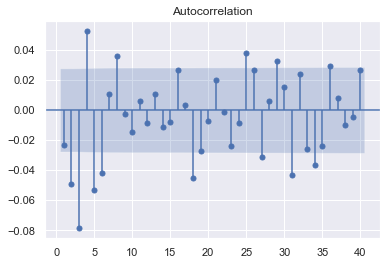

In [33]:
sgt.plot_acf(df.returns[1:], zero=False, lags=40)
plt.show()

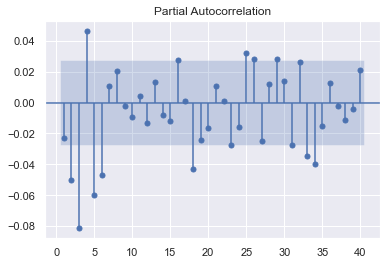

In [34]:
sgt.plot_pacf(df.returns[1:], zero=False, lags=40)
plt.show()

# ARMA(3, 3)

We still want a complicated model. By reducing the order by 1 from ARMA(3, 3), we begin with the models that consist of five total orders. ARMA(3, 2) and ARMA(2, 3). It makes little difference which one we try first. So, let's start with ARMA(3, 2).

In [8]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order=(3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [9]:
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 28 Jan 2021   AIC                          15803.030
Time:                        23:22:37   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

The first coefficients for AR and MA are not significant.

Is this better than ARMA(1,1)?

In [10]:
print("ARMA(1,1) vs ARMA(3,3):", LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, 4))

ARMA(1,1) vs ARMA(3,3): 0.0


ARMA(3, 3) is better than ARMA(1, 1). But is ARMA(3, 3) optimal? The best fit would lie between ARMA(1, 1) and ARMA(3, 3). How can we find the best one though?

# ARMA(3, 2)

We still want a complicated model. By reducing the order by 1 from ARMA(3, 3), we begin with the models that consist of five total orders. ARMA(3, 2) and ARMA(2, 3). It makes little difference which one we try first. So, let's start with ARMA(3, 2).

In [15]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order=(3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 28 Jan 2021   AIC                          15805.495
Time:                        23:29:06   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5101j            1.5885           -0.3002
AR.2           -0.4929           +1.5101j            1.5885            0.3002
AR.3           -3.4748           -0.0000j            3.4748           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

All of the p-values are significant except for the constant, but the returns in an efficient market should be close to 0 anyway so it shouldn't bother us. 

The absolute value of the coefficients decreases for the higher lags. This supports the idea that the further back in time we go, the less relevant values and errors become. It doesn't have to be the way always, but such a trend makes our predictions seem much more realistic.

Plus, positive MA coefficients suggest calibration efforts. If our prediction was lower than the actual value, we get a positive residual value (error = actual - predicted). With the positive error and positive coefficient, we get a positive MA component. ($\epsilon_t > 0$ ==> $\theta\epsilon_t > 0$) This results in an increase in the value of our predictions for the next period. So we try to close the gap to the actual value hoping the pattern will translate into the future. On the other hand, if the prediction was higher than the actual, the MA component will be negative (negative residual * positive coefficient). This will decrease the prediction for the next period. 

What about the negative AR coefficients? Those more or less match our expectations of an efficient market. If returns are positive, then multiplying the values by a negative factor will move thir effect in the opposite direction. We expect an efficient market to have a mean of zero over time. Therefore, every period of positive returns is followed by one with negative returns. The assumption is that it allows us to remain close to the mean of zero regardless of the starting and ending periods of our sample.


Also, in this case, we don't have to test LLR test because ARMA(3, 2) satisfies the criteria and is a simpler model. 


# ARMA(2, 3)

In [11]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 28 Jan 2021   AIC                          15805.174
Time:                        23:23:34   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

We shouldn't use this because of the p-value of MA(2) but we can perform LLR test. 

In [14]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

0.042

The value suggests the difference is significant but just barely. This indicates we should opt for the ARMA(3, 3) model instead of the ARMA(2, 3) if we had to choose only between these two. 

# ARMA(3, 1)

In [16]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order=(3,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
results_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sat, 30 Jan 2021   AIC                          15810.144
Time:                        23:53:22   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

The p-values are all 0 and all AR coefficients are negative and all MA coefficients are positive, which makes sense in a financial point of view. 

In [17]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

0.01

Remember we need to put the simpler model first. 

P-value of 0.01 in the LLR test (lower than 0.05) means the ARMA(3, 2) is better than ARMA(3, 1)

# ARMA(2, 2)

In [18]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order=(2,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Sat, 30 Jan 2021   AIC                          15838.446
Time:                        23:55:31   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8105      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5017           -0.3739j            2.5295           -0.0236
AR.2            2.5017           +0.3739j            2.5295            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2738           +0.0000j            5.2738            0.0000
-----------------------------------------------------------------------------
"""

Two of the coefficients have high p-values. Both happen to be the Lag 2. This leads us to believe that ARMA(2, 1) or ARMA(1, 2) would outperform ARMA(2, 2) and we would want to avoid ARMA(2, 2) at all cost.

# ARMA(3, 1)

In [19]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order=(1, 3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Mon, 01 Feb 2021   AIC                          15805.676
Time:                        23:39:01   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

All coefficients are significant based on the p-values so this has a chance to be a good predictor.

Usually, we will go on to use the Log-likelihood ratio test here to compare it with the ARMA(3, 2) but ARMA(3, 2) and ARMA(1, 3) aren't nested. Of course, such an issue could never occur with strictly AR or MA models because any lower lag models are nested in more complicated ones. 

To elaborate this notion, suppose we have two models of interest: ARMA(P1, Q1) and ARMA(P2, Q2). The second model is "nested" if and only if the following conditions are satisfied:  
1) P1 + Q1 > P2 + Q2  
2) P1 >= P2   
3) Q1 >= Q2   

In our case, ARMA(3, 2) and ARMA(1, 3) aren't nested so the LLR test becomes void. In this case, we manually compare the log likelihoods and AICs of both models. The preferred model has higher LLR and lower AIC. 


In [23]:
print("ARMA(3, 2): LL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("ARMA(1, 3): LL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)

ARMA(3, 2): LL =  -7895.747458514483 	AIC =  15805.494917028966
ARMA(1, 3): LL =  -7896.837893752798 	AIC =  15805.675787505596


ARMA(3, 2) has higher LL and lower AIC. So, ARMA(3, 2) is better than ARMA(1, 3).

# Others

ARMA(1, 2) and ARMA(2, 1) both yield non-significant coefficient at the 5% significance level so we don't need to bother to compare them with ARMA(3, 2). 

So the best model seems to be the best model as 

1) all coefficients are significant,  
2) outpredicts all less-complex alternatives. 


# Residual for Returns

Test if residuals match our expectations for white noise.

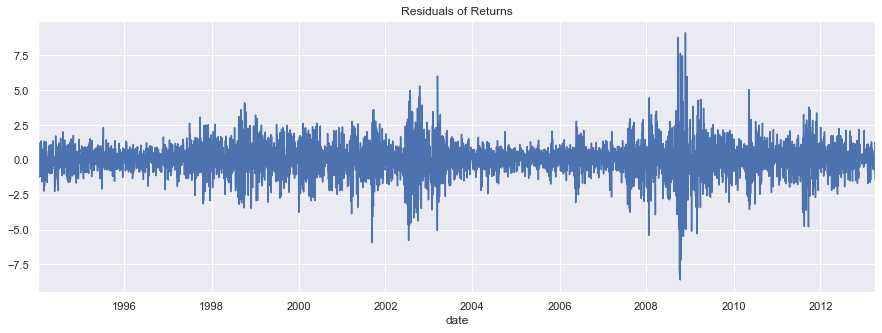

In [25]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

df.res_ret_ar_3_ma_2.plot(figsize=(15, 5))
plt.title("Residuals of Returns")
plt.show()

The results look similar to the AR and MA models. This suggests that the volatility in returns might not be fully comprehensible if we use only ARMA models.

Let's check if residuals are random. If there is a pattern in the residuals, it means there is a factor we hadn't accounted for in our regression. 

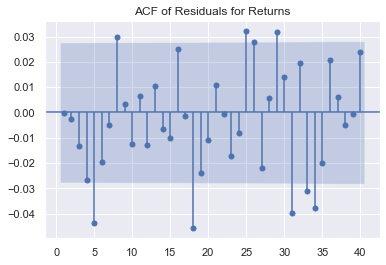

In [27]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero=False, lags=40)
plt.title("ACF of Residuals for Returns")
plt.show()

Having significant residual in the 5th lag suggests that the lag 5 might need to be included in the model. We can start with ARMA(5, 5) and go through the models which are ARMA(5, Q) or ARMA(P, 5). 

Once we find all the models with all coefficients significant, we will run the LLR test for nested ones and compare log likelihood and AIC values or the others.

# Reevaluating Model Selection

If we test all ARMA models including ARMA(1, 5), ..., ARMA(5, 1), ..., ARMA(5,5), there are only two models that have all significant coefficients: ARMA(1, 5) and ARMA(5, 1). 

ARMA(1, 5) and ARMA(5, 1) are viable so we can't apply the LLR tst. Instead we must compare their log likelihood and AIC values.

## ARMA(1, 5)

In [28]:
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order=(1, 5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 02 Feb 2021   AIC                          15797.947
Time:                        23:29:37   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     -2.332      0.020      -0.650      -0.056
ma.L2.returns    -0.0404      0.015     -2.624      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0742      0.020      3.771      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.660      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0443           +0.0000j            3.0443            0.0000
MA.1           -1.1897           -1.1548j            1.6580           -0.3774
MA.2           -1.1897           +1.1548j            1.6580            0.3774
MA.3            1.5041           -0.0000j            1.5041           -0.0000
MA.4            0.9809           -1.6057j            1.8815           -0.1627
MA.5            0.9809           +1.6057j            1.8815            0.1627
-----------------------------------------------------------------------------
"""

## ARMA(5, 1)

In [29]:
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order=(5, 1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 02 Feb 2021   AIC                          15794.623
Time:                        23:29:57   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     -3.005      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.068      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.688      0.000      -0.109      -0.053
ma.L1.returns    -0.3673      0.131     -2.801      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6158           -0.0000j            1.6158           -0.5000
AR.2            1.3793           -0.8613j            1.6261           -0.0888
AR.3            1.3793           +0.8613j            1.6261            0.0888
AR.4           -0.1156           -1.6929j            1.6968           -0.2608
AR.5           -0.1156           +1.6929j            1.6968            0.2608
MA.1            2.7223           +0.0000j            2.7223            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
print("ARMA(1, 5): LL = ", results_ret_ar_1_ma_5.llf, "\tAIC = ", results_ret_ar_1_ma_5.aic)
print("ARMA(5, 1): LL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)

ARMA(1, 5): LL =  -7890.973460209448 	AIC =  15797.946920418895
ARMA(5, 1): LL =  -7889.31128294583 	AIC =  15794.62256589166


ARMA(5, 1) has higher log likelihood and lower AIC, so it's the superior choice.

In [32]:
print("ARMA(3, 2): LL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("ARMA(5, 1): LL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)

ARMA(3, 2): LL =  -7895.747458514483 	AIC =  15805.494917028966
ARMA(5, 1): LL =  -7889.31128294583 	AIC =  15794.62256589166


ARMA(5, 1) has higher log likelihood and lower AIC, so it's the even more superior choice than ARMA(3, 2). The ARMA(3, 2) might have been way too simplistic for the task.

AR and MA models have ACF and PACF that provide the suggested optimal number of lags needed. Unfortunately, ARMA models lack such functions. Therefore, we can make the mistake of starting off with a model, whose order is lower than the optimal one. This is why examining the residuals is crucial in finding the best approximate.

Now we can check the residulas for ARMA(5, 1) again.

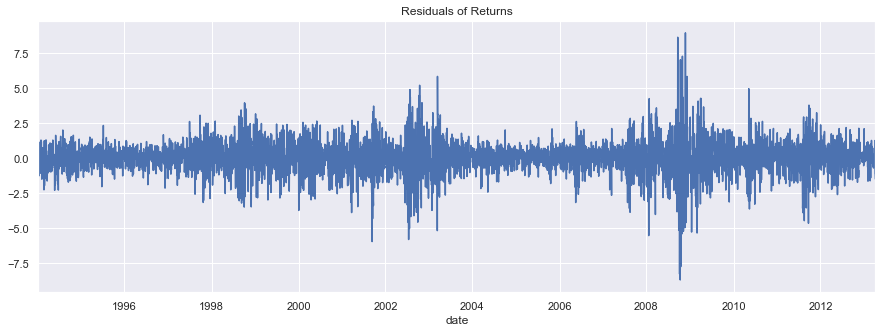

In [35]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid[1:]

df.res_ret_ar_5_ma_1.plot(figsize=(15, 5))
plt.title("Residuals of Returns")
plt.show()

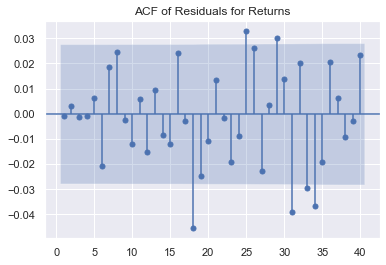

In [36]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[2:], zero=False, lags=40)
plt.title("ACF of Residuals for Returns")
plt.show()

We see that not only is the 5th lag not significant anymore but neither is the 8th nor any other lag before the 18th. If we want our model to resemble the data set more closely, we could include even more into our model. However, this will predispose the model to failture when facing unfamiliar data. Including so many lags will help us know with confidence how this specific data set moves rather than understand how the actual market returns fluctuate. 

So, as we stated earlier the effects of returns and errors tend to diminish. Therefore, the further back in time we go, the less relevant the values are. Since more than 10 of the first lags are not significant we can say the residuals are pretty much random, which is what we are trying to achieve. 

# ARMA for Prices

How would ARMA models perform when they are fed non-stationary data? Let's reapply the same approach we used on returns and see how using non-stationary data affects our work. 

So far, we checked the AR and MA models fail at prediction non-stationary data on their own. Before we fit an over-parameterized model, let's quickly check ACF and PACF.

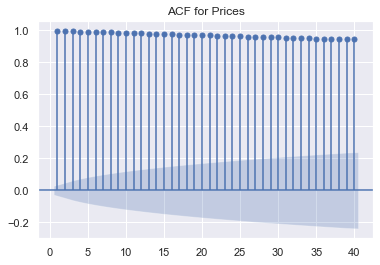

In [38]:
sgt.plot_acf(df.market_value, unbiased=True, zero=False, lags=40)
plt.title("ACF for Prices")
plt.show()

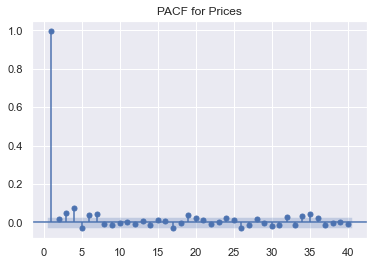

In [40]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, method=('ols'))
plt.title("PACF for Prices")
plt.show()

All 40 ACF coefficients are significant as well as first 6 PACF coefficients. The ACF graph suggests using infinitely many components which is unrealistic. Lucky for us, the additional materials in the previous section showed how an infinite MA lag model with certain restriction is equivalent to a simple AR model. Therefore, as long as we include AR components we should be able to describe the data well by using a finite number of total lags. 

Let's first fit a simple ARMA model.

In [41]:
model_ar_1_ma_1 = ARMA(df.market_value, order=(1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.784
Method:                       css-mle   S.D. of innovations             59.248
Date:                Wed, 03 Feb 2021   AIC                          55251.568
Time:                        20:18:22   BIC                          55277.654
Sample:                    01-07-1994   HQIC                         55260.709
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5031.5678    496.810     10.128      0.000    4057.837    6005.298
ar.L1.market_value     0.9985      0.001   1324.999      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5113           +0.0000j           52.5113            0.0000
-----------------------------------------------------------------------------
"""

By looking at the P-values, we notice the constant and AR component is significant but not the MA component. Before choosing over parameterized models, we can examine the residuals.

In [43]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

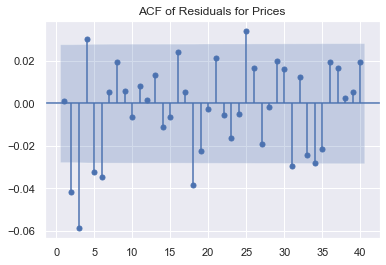

In [45]:
sgt.plot_acf(df.res_ar_1_ma_1, zero=False, lags=40)
plt.title("ACF of Residuals for Prices")
plt.show()

We can see that five of the first six lags are significant. So we must amend this by accounting for up to that many lags in our model.

## ARMA(6, 6)

In [46]:
model_ar_6_ma_6 = ARMA(df.market_value, order=(6, 6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
results_ar_6_ma_6.summary()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

This throws an error that the initial AR coefficients are not stationary. To fix the problem, we can take one of the three approaches;

1) Induce stationary by transforming the data into returns: we do not want to do this here  
2) Choose a different model order: we want to avoid this because we are interested in the coefficients of 6th lag  
3) Setting initial parameters: we will use this method.  


We set the `start_ar_lags` parameter to `fit` method. We can increase the lag until we do not see the error, which turns out to be 11. 

In [47]:
model_ar_6_ma_6 = ARMA(df.market_value, order=(6, 6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags=11)
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Wed, 03 Feb 2021   AIC                          55203.864
Time:                        20:30:33   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6496    568.515      8.953      0.000    3975.380    6203.919
ar.L1.market_value     1.9270      0.032     59.946      0.000       1.864       1.990
ar.L2.market_value    -1.7355      0.040    -43.395      0.000      -1.814      -1.657
ar.L3.market_value     1.2678      0.034     36.864      0.000       1.200       1.335
ar.L4.market_value    -0.2376      0.156     -1.524      0.127      -0.543       0.068
ar.L5.market_value    -0.4056      0.163     -2.486      0.013      -0.725      -0.086
ar.L6.market_value     0.1834      0.049      3.760      0.000       0.088       0.279
ma.L1.market_value    -0.9481      0.035    -27.039      0.000      -1.017      -0.879
ma.L2.market_value     0.7800      0.032     24.216      0.000       0.717       0.843
ma.L3.market_value    -0.5085      0.031    -16.336      0.000      -0.570      -0.447
ma.L4.market_value    -0.1560      0.157     -0.997      0.319      -0.463       0.151
ma.L5.market_value     0.0947      0.057      1.672      0.094      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.825      0.005       0.021       0.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0502j            1.0537           -0.2370
AR.2            0.0857           +1.0502j            1.0537            0.2370
AR.3           -2.0271           -0.0000j            2.0271           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5328           -0.2647j            1.5555           -0.0272
AR.6            1.5328           +0.2647j            1.5555            0.0272
MA.1            0.1028           -1.0612j            1.0661           -0.2346
MA.2            0.1028           +1.0612j            1.0661            0.2346
MA.3            1.3634           -0.2787j            1.3916           -0.0321
MA.4            1.3634           +0.2787j            1.3916            0.0321
MA.5           -2.1727           -1.4351j            2.6039           -0.4071
MA.6           -2.1727           +1.4351j            2.6039            0.4071
-----------------------------------------------------------------------------
"""

We can also change ARMA order until we have all significant coefficients. 

In [50]:
model_ar_5_ma_6 = ARMA(df.market_value, order=(5, 6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags=7)
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Wed, 03 Feb 2021   AIC                          55201.726
Time:                        20:35:04   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6480    580.839      8.763      0.000    3951.224    6228.072
ar.L1.market_value     1.3584      0.178      7.651      0.000       1.010       1.706
ar.L2.market_value    -1.1289      0.237     -4.759      0.000      -1.594      -0.664
ar.L3.market_value     0.9147      0.229      3.999      0.000       0.466       1.363
ar.L4.market_value     0.0159      0.204      0.078      0.938      -0.383       0.415
ar.L5.market_value    -0.1613      0.119     -1.352      0.176      -0.395       0.073
ma.L1.market_value    -0.3796      0.178     -2.132      0.033      -0.729      -0.031
ma.L2.market_value     0.7294      0.125      5.829      0.000       0.484       0.975
ma.L3.market_value    -0.2198      0.153     -1.437      0.151      -0.520       0.080
ma.L4.market_value    -0.1387      0.114     -1.215      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.325      0.000      -0.120      -0.056
ma.L6.market_value     0.0265      0.024      1.128      0.259      -0.020       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0458           -0.2360
AR.2            0.0917           +1.0418j            1.0458            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8980           -0.0000j            1.8980           -0.0000
AR.5           -2.9839           -0.0000j            2.9839           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5353           -1.5157j            2.1574           -0.3760
MA.4           -1.5353           +1.5157j            2.1574            0.3760
MA.5            1.5919           -0.0000j            1.5919           -0.0000
MA.6            4.5787           -0.0000j            4.5787           -0.0000
-----------------------------------------------------------------------------
"""

In [51]:
model_ar_6_ma_1 = ARMA(df.market_value, order=(6, 1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags=7)
results_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Wed, 03 Feb 2021   AIC                          55206.389
Time:                        20:35:08   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6420    586.493      8.678      0.000    3940.137    6239.147
ar.L1.market_value     1.3921      0.058     23.929      0.000       1.278       1.506
ar.L2.market_value    -0.4369      0.059     -7.400      0.000      -0.553      -0.321
ar.L3.market_value    -0.0101      0.025     -0.409      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1158      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.067      0.000       0.030       0.085
ma.L1.market_value    -0.4127      0.060     -6.925      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7608           -0.0000j            1.7608           -0.5000
AR.3           -0.0803           -1.8407j            1.8425           -0.2569
AR.4           -0.0803           +1.8407j            1.8425            0.2569
AR.5            1.4694           -0.8691j            1.7072           -0.0850
AR.6            1.4694           +0.8691j            1.7072            0.0850
MA.1            2.4233           +0.0000j            2.4233            0.0000
-----------------------------------------------------------------------------
"""

In [53]:
print("ARMA(5, 6): LL = ", results_ar_5_ma_6.llf, "\tAIC = ", results_ar_5_ma_6.aic)
print("ARMA(6, 1): LL = ", results_ar_6_ma_1.llf, "\tAIC = ", results_ar_6_ma_1.aic)

ARMA(5, 6): LL =  -27587.862948592527 	AIC =  55201.72589718505
ARMA(6, 1): LL =  -27594.19457097668 	AIC =  55206.38914195336


In this case, we want to use ARMA(5, 6).

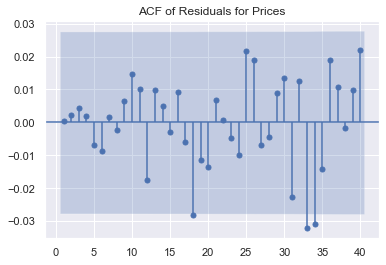

In [54]:
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero=False, lags=40)
plt.title("ACF of Residuals for Prices")
plt.show()

This looks like a good residual ACF for white noise.

# ARMA for Returns vs. ARMA for Prices

In [56]:
print("ARMA(5, 6): LL = ", results_ar_5_ma_6.llf, "\tAIC = ", results_ar_5_ma_6.aic)
print("ARMA(5, 1): LL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)

ARMA(5, 6): LL =  -27587.862948592527 	AIC =  55201.72589718505
ARMA(5, 1): LL =  -7889.31128294583 	AIC =  15794.62256589166


This suggests that even though we can model prices using ARMA models, they perform much worse compared to their ability to estimate stationary data.